In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import lightgbm as lgb
import time
import numpy as np

In [2]:
#%% Lendo os dados
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [3]:
# Identificar e remover colunas duplicadas
duplicated_columns = X_train.columns[X_train.columns.duplicated()]
print(f'Colunas duplicadas: {duplicated_columns}')
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

Colunas duplicadas: Index([], dtype='object')


In [4]:
#%% Ajuste de Índice
X_train.set_index('subject', append=True, inplace=True)
X_test.set_index('subject', append=True, inplace=True)

In [5]:
#%% Adicionando a coluna de resposta no dataframe de treino
HAR_train = pd.concat([X_train.reset_index(), y_train], axis=1).set_index(['level_0', 'subject'])


In [6]:
#%% Visualizar Colunas
print(HAR_train.columns)

Index(['000-tBodyAcc-mean-X', '001-tBodyAcc-mean-Y', '002-tBodyAcc-mean-Z',
       '003-tBodyAcc-std-X', '004-tBodyAcc-std-Y', '005-tBodyAcc-std-Z',
       '006-tBodyAcc-mad-X', '007-tBodyAcc-mad-Y', '008-tBodyAcc-mad-Z',
       '009-tBodyAcc-max-X',
       ...
       '552-fBodyBodyGyroJerkMag-skewness',
       '553-fBodyBodyGyroJerkMag-kurtosis', '554-angletBodyAccMeangravity',
       '555-angletBodyAccJerkMeangravityMean',
       '556-angletBodyGyroMeangravityMean',
       '557-angletBodyGyroJerkMeangravityMean', '558-angleXgravityMean',
       '559-angleYgravityMean', '560-angleZgravityMean', 'label'],
      dtype='object', length=562)


/tmp/ipykernel_3597/2416808333.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)
/tmp/ipykernel_3597/2416808333.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
/tmp/ipykernel_3597/2416808333.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=30)


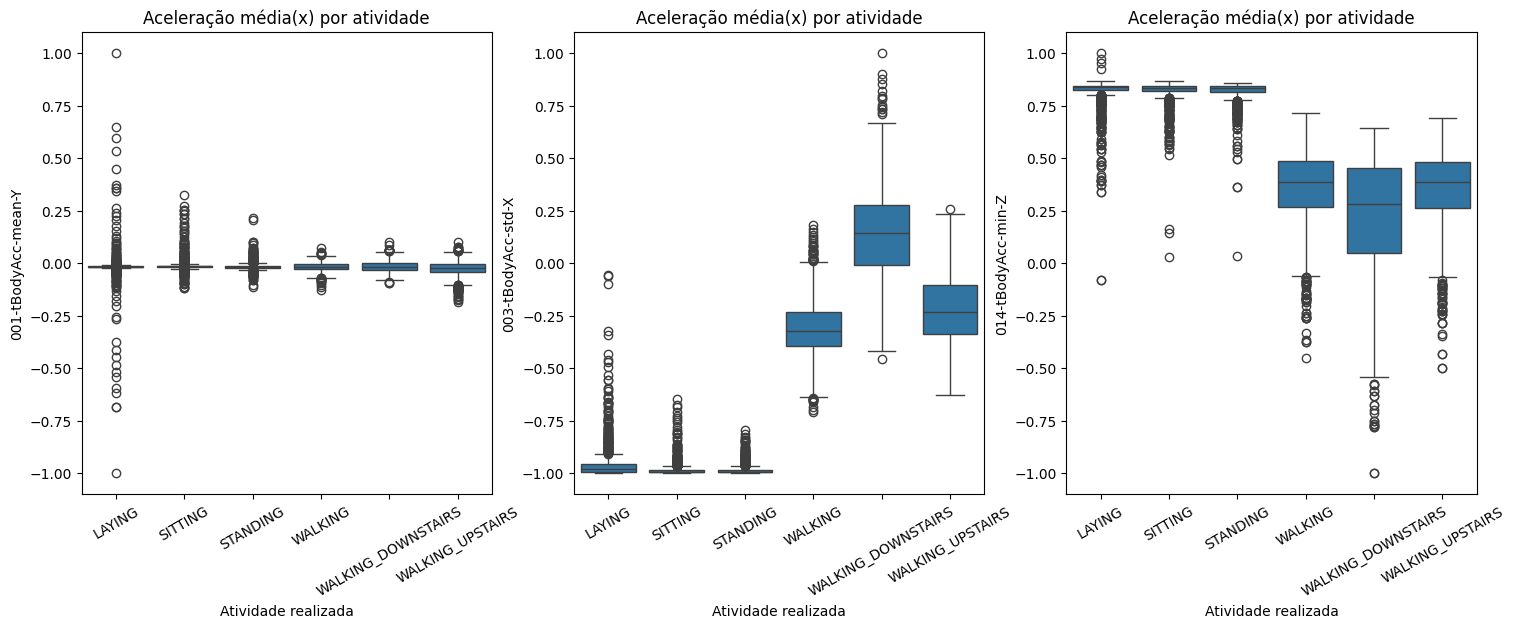

In [7]:
#%% Análise Descritiva Básica
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=HAR_train, x='label', y=HAR_train.iloc[:, 1], ax=axs[0])
axs[0].set_xlabel("Atividade realizada")
axs[0].set_ylabel(HAR_train.columns[1])
axs[0].set_title("Aceleração média(x) por atividade")
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.boxplot(data=HAR_train, x='label', y=HAR_train.iloc[:, 3], ax=axs[1])
axs[1].set_xlabel("Atividade realizada")
axs[1].set_ylabel(HAR_train.columns[3])
axs[1].set_title("Aceleração média(x) por atividade")
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)

sns.boxplot(data=HAR_train, x='label', y=HAR_train.iloc[:, 14], ax=axs[2])
axs[2].set_xlabel("Atividade realizada")
axs[2].set_ylabel(HAR_train.columns[14])
axs[2].set_title("Aceleração média(x) por atividade")
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=30)

plt.show()

In [8]:
#%% Treinamento do Modelo de Decisão
np.random.seed(1729)
tempo_ini = time.time()
arvore = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2)
arvore.fit(X_train, y_train)
tempo_fim = time.time()
print(f'Tempo de treinamento da árvore: {tempo_fim - tempo_ini} segundos')

importancias = pd.DataFrame(arvore.feature_importances_, index=X_train.columns, columns=['importancia'])
top_10_variaveis = importancias.sort_values(by='importancia', ascending=False)[:10]
print(f'Top 10 variaveis: {top_10_variaveis}')


Tempo de treinamento da árvore: 2.4727649688720703 segundos
Top 10 variaveis:                                   importancia
389-fBodyAccJerk-bandsEnergy-116     0.417352
052-tGravityAcc-min-X                0.217220
504-fBodyAccMag-mad                  0.091258
559-angleYgravityMean                0.076230
074-tGravityAcc-arCoeff-Z2           0.058416
448-fBodyGyro-maxInds-X              0.016524
159-tBodyGyro-correlation-YZ         0.013493
057-tGravityAcc-energy-Y             0.013026
037-tBodyAcc-correlation-XY          0.012383
049-tGravityAcc-max-X                0.011793


In [9]:
# Selecionar as 20 variáveis com maior importância
variaveis = importancias.nlargest(20, 'importancia').index.tolist()
print(f'Variáveis selecionadas: {variaveis}')


Variáveis selecionadas: ['389-fBodyAccJerk-bandsEnergy-116', '052-tGravityAcc-min-X', '504-fBodyAccMag-mad', '559-angleYgravityMean', '074-tGravityAcc-arCoeff-Z2', '448-fBodyGyro-maxInds-X', '159-tBodyGyro-correlation-YZ', '057-tGravityAcc-energy-Y', '037-tBodyAcc-correlation-XY', '049-tGravityAcc-max-X', '039-tBodyAcc-correlation-YZ', '274-fBodyAcc-max-X', '508-fBodyAccMag-energy', '275-fBodyAcc-max-Y', '354-fBodyAccJerk-max-Y', '129-tBodyGyro-max-X', '451-fBodyGyro-meanFreq-X', '075-tGravityAcc-arCoeff-Z3', '053-tGravityAcc-min-Y', '222-tGravityAccMag-arCoeff1']


In [10]:
# Parâmetros para o Grid Search
param_grid = {
    'num_leaves': [31],
    'max_depth': [3, 10],
    'learning_rate': [0.05, 0.2],
    'n_estimators': [5, 11]
}


In [11]:
#%% Verificação de Valores Faltantes
print(X_train[variaveis].isna().sum())
print(y_train.isna().sum())


389-fBodyAccJerk-bandsEnergy-116    0
052-tGravityAcc-min-X               0
504-fBodyAccMag-mad                 0
559-angleYgravityMean               0
074-tGravityAcc-arCoeff-Z2          0
448-fBodyGyro-maxInds-X             0
159-tBodyGyro-correlation-YZ        0
057-tGravityAcc-energy-Y            0
037-tBodyAcc-correlation-XY         0
049-tGravityAcc-max-X               0
039-tBodyAcc-correlation-YZ         0
274-fBodyAcc-max-X                  0
508-fBodyAccMag-energy              0
275-fBodyAcc-max-Y                  0
354-fBodyAccJerk-max-Y              0
129-tBodyGyro-max-X                 0
451-fBodyGyro-meanFreq-X            0
075-tGravityAcc-arCoeff-Z3          0
053-tGravityAcc-min-Y               0
222-tGravityAccMag-arCoeff1         0
dtype: int64
label    0
dtype: int64


In [12]:
#%% Preparação da Variável y
y = y_train['label'].cat.codes


In [13]:
#%% Configuração de GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1729)
scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')


In [14]:
# Inicia o cronômetro
tempo_ini = time.time()


In [15]:
# Definindo o modelo LightGBM
modelo = lgb.LGBMClassifier(objective='multiclass', random_state=1729)


In [16]:
# Realizando o Grid Search
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scorer, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train[variaveis], y)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.277703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.377105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Start training from score -1.653445
[LightGBM] [Info] Number of data points in the train set: 4902, number of used features: 20
[LightGBM] [Info] Start training from score -1.743757
[LightGBM] [Info

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Info] Start training from score -1.677178
[LightGBM] [Info] Start training from score -1.742794
[LightGBM] [Info] Start training from score -1.790332
[LightGBM] [Info] Start training from score -1.677382
[LightGBM] [Info] Start training from score -2.009511
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.924912
[LightGBM] [Info] Start training from score -2.009715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.923718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Info] Start training from score -1.791555
[LightGBM] [Info] Start training from score -2.007990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.446500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4866
[LightGBM] [Info] Start training from score -1.924912
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.653445
[LightGBM] [Info] Start training from score -1.743757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.677178
[LightGBM] [Info] Start training from score -1.790332
[LightGBM] [Info] Start training from score -2.009511
[LightGBM] [Info] Start training from score -1.924912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.384841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 4902, number of used features: 20
[LightGBM] [Info] Number of data points in

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4866
[LightGBM] [Info] Number of data points in the train set: 4901, number of used features: 20
[LightGBM] [Info] Start training from score -1.653445


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Info] Start training from score -1.743757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.677178
[LightGBM] [Info] Start training from score -1.790332
[LightGBM] [Info] Start training from score -2.009511
[LightGBM] [Info] Start training from score -1.924912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.316212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4867
[LightGBM] [Info] Number of data points in the train set: 4902, number of used features: 20
[LightGBM] [Info] Start training from score -1.653649
[LightGBM] [Info] Start training from score -1.742794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.677382
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -2.009715
[LightGBM] [Info] Star

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/usr/lib/python3.10/inspect.py"

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4868
[LightGBM] [Info] Number of data points in the train set: 7352, number of used features: 20
[LightGBM] [Info] Start training from score -1.653513
[LightGBM] [Info] Start training from score -1.743436
[LightGBM] [Info] Start training from score -1.677246
[LightGBM] [Info] Start training from score -1.791216
[LightGBM] [Info] Start training from score -2.009071
[LightGBM] [Info] Start training from score -1.924514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1729, shuffle=True),
             estimator=LGBMClassifier(objective='multiclass',
                                      random_state=1729),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.2], 'max_depth': [3, 10],
                         'n_estimators': [5, 11], 'num_leaves': [31]},
             scoring=make_scorer(roc_auc_score, response_method='predict', needs_proba=True, multi_class=ovr),
             verbose=1)

In [17]:
# Finaliza o cronômetro
tempo_fim = time.time()
print(f'Tempo de treinamento do Grid Search: {tempo_fim - tempo_ini} segundos')


Tempo de treinamento do Grid Search: 2676.2860362529755 segundos


In [18]:
# Exibindo os melhores parâmetros
print(f'Melhores Parâmetros: {grid_search.best_params_}')
resultados_cv = pd.DataFrame(grid_search.cv_results_)

#%%

pred_test = pd.Series(grid_search.best_estimator_.predict(X_test[variaveis]))

print(pd.crosstab(pred_test, y_test.label))

acurácia = (pred_test == y_test.label.cat.codes).sum()/len(y_test)

print(f'acurácia = {acurácia:.2%}')

Melhores Parâmetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 5, 'num_leaves': 31}
label  LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
row_0                                                           
0         537        0         1        3                  21   
1           0      417       103        0                   0   
2           0       73       428        0                   0   
3           0        0         0      466                  39   
4           0        0         0       17                 332   
5           0        1         0       10                  28   

label  WALKING_UPSTAIRS  
row_0                    
0                    45  
1                     1  
2                     0  
3                    77  
4                     6  
5                   342  
acurácia = 85.58%
